# **Importing Important Libraries**

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib 
import os 
import PIL
from PIL import Image

# **Loading and Preprocessing Data**

In [20]:
data_dir = pathlib.Path("Custom-Dataset")
# print(len(list(data_dir.glob("*/*"))))


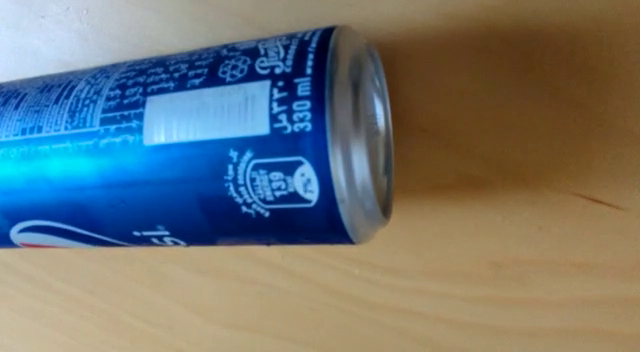

In [3]:
# DONT RUN THIS FOR NOW
trash = list(data_dir.glob('Can/*'))
PIL.Image.open(str(trash[0]))

In [21]:
batch_size = 32
image_height = 224
image_width = 224

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 23343 files belonging to 3 classes.
Using 21009 files for training.


In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 23343 files belonging to 3 classes.
Using 2334 files for validation.


In [24]:
# Evaluate the best model on the test data
test_ds = keras.preprocessing.image_dataset_from_directory(
    'Dataset-testing (from internet)',
    image_size=(224, 224),
    batch_size=32)

Found 699 files belonging to 3 classes.


In [7]:
# DONT RUN THIS FOR NOW
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [8]:
# DONT RUN THIS FOR NOW

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 37
Number of test batches: 36


In [25]:
# DONT RUN THIS FOR NOW

#Classes as inferred
class_names = train_ds.class_names
print(class_names)

['Can', 'Paper', 'Plastic']


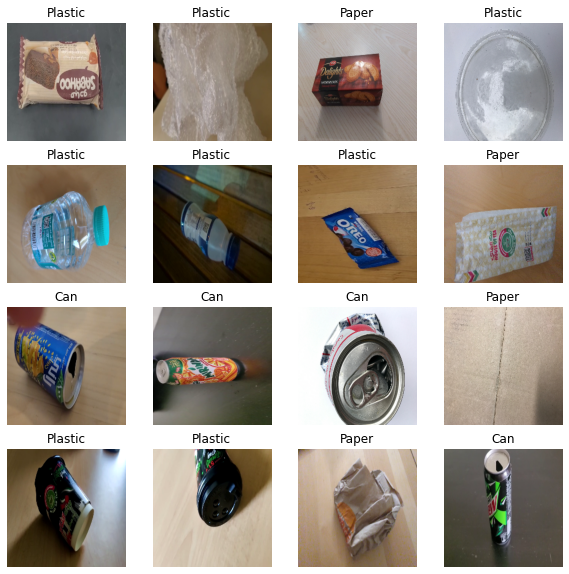

In [10]:
# DONT RUN THIS FOR NOW

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# DONT RUN THIS FOR NOW


for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# **Configure Dataset Performance**

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
# test_ds= test_ds.prefetch(buffer_size=AUTOTUNE)

# **Data Augmentation**

In [27]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

## Load The Pre-trained Model - **VGG16**

In [28]:
# DONT RUN THIS FOR NOW


#importing VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [15]:
# DONT RUN THIS FOR NOW

!pip install keras-tuner --upgrade

In [29]:
# DONT RUN THIS FOR NOW

from kerastuner import Hyperband

In [30]:
# DONT RUN THIS FOR NOW


def build_model (hp):
  base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
  )

  #Not training base model
  base_model.trainable = False 

  drop = layers.Dropout(hp.Choice("Dropouts", [0.05,0.75,0.1,0.125,0.15,0.175,0.2,0.225]))
  flat = layers.Flatten()
  # d1 = layers.Dense(512,activation='relu')
  # d2 = layers.Dense(256,activation='relu')
  prediction_layer = layers.Dense(3,activation='softmax')


  inputs = tf.keras.Input(shape=(image_height, image_width, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = drop(x)
  x = flat(x)
  
  for i in range(hp.Int("Dense Layers", min_value=3, max_value=7)):
    x = layers.Dense(hp.Choice(f"layer_{i}_filters", [64,128,256,512,1024]),activation='relu')(x)

  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)


  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('adam_learning_rate', [0.5*(1e-2),1e-2,0.5*(1e-3) ,1e-3, 0.5*(1e-4),1e-4])),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

  return model

In [31]:
# DONT RUN THIS FOR NOW

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    overwrite=False,
    directory='New_Tuner',
    project_name='fine_tuner_hyperband')

## From VGG_STBv1.2

In [ ]:
!pwd

/home/ai-05/Desktop/sdp


In [ ]:
# DONT RUN THIS FOR NOW

model = tf.keras.models.load_model("ResNet50-STBv1.0_6")
# vgg16_stb_v1_2_1.summary()

In [ ]:
# DONT RUN THIS FOR NOW

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                             

In [ ]:
model.layers[2].layers[2].get_config()

{'name': 'conv1_conv',
 'trainable': True,
 'dtype': 'float32',
 'filters': 64,
 'kernel_size': (7, 7),
 'strides': (2, 2),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [ ]:
for layer in model.layers[2].layers:
    layer.trainable = False

In [ ]:
for layer in model.layers[2].layers[1:38]: # 1 n 2
    layer.trainable = True

## ResNet50

### Fine Tuning
Make the specified block trainable, freeze others 

In [ ]:
# DONT RUN THIS FOR NOW

vgg16_stb_v1_2_7.trainable = False

In [ ]:
# DONT RUN THIS FOR NOW

for m in vgg16_stb_v1_2_7.layers:
  print(m.trainable)

False
False
False
False
False
False
False
False
False


In [ ]:
vgg16_stb_v1_2_7.layers[4].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# DONT RUN THIS FOR NOW


for m in vgg16_stb_v1_2_7.layers[4].layers:
      m.trainable = True

In [ ]:
# DONT RUN THIS FOR NOW

for m in vgg16_stb_v1_2_7.layers[4].layers:
  print(m.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/Tuner/v_gg16_stb_v1_2_3.02-4.8675.h5"

In [ ]:
# If loaded the model and not want to create model.

vgg16_stb_v1_2_3 = keras.models.load_model(checkpoint_filepath)
vgg16_stb_v1_2_3.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
# DONT RUN THIS FOR NOW 
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
# vgg16_stb_v1_2_7.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Evaluating on a new dataset from the internet
# paper and plastic from  https://www.kaggle.com/datasets/arthurcen/waste-images-from-sushi-restaurant
# can from https://universe.roboflow.com/dataset-t7hz7/cans-fdboa/dataset/1
test_dir = pathlib.Path("Dataset-testing (from internet)")

batch_size = 32
image_height = 224
image_width = 224

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 699 files belonging to 3 classes.


In [ ]:
# Define the checkpoint filepath
# checkpoint_filepath = "/content/drive/MyDrive/Tuner/fine_tuner_4.h5"

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='Tuner/resnet50_stb_v1_0_7.{epoch:02d}.h5',
    save_weights_only=False,
    save_best_only=False,
    save_freq='epoch',
    verbose=1)

# Train the model and save the history and model at each epoch
history = model.fit(train_ds, validation_data=test_ds, epochs=30, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/30


591/591 [==============================] - ETA: 0s - loss: 0.8939 - accuracy: 0.5854
Epoch 1: saving model to Tuner/resnet50_stb_v1_0_7.01.h5
591/591 [==============================] - 1000s 2s/step - loss: 0.8939 - accuracy: 0.5854 - val_loss: 0.9310 - val_accuracy: 0.6309
Epoch 2/30
591/591 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.8699
Epoch 2: saving model to Tuner/resnet50_stb_v1_0_7.02.h5
591/591 [==============================] - 985s 2s/step - loss: 0.3483 - accuracy: 0.8699 - val_loss: 1.3224 - val_accuracy: 0.6123
Epoch 3/30
591/591 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9149
Epoch 3: saving model to Tuner/resnet50_stb_v1_0_7.03.h5
591/591 [==============================] - 997s 2s/step - loss: 0.2445 - accuracy: 0.9149 - val_loss: 1.1881 - val_accuracy: 0.6681
Epoch 4/30
591/591 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9290
Epoch 4: saving model to Tuner/resnet50_stb_v1_0_7.04.h5
59

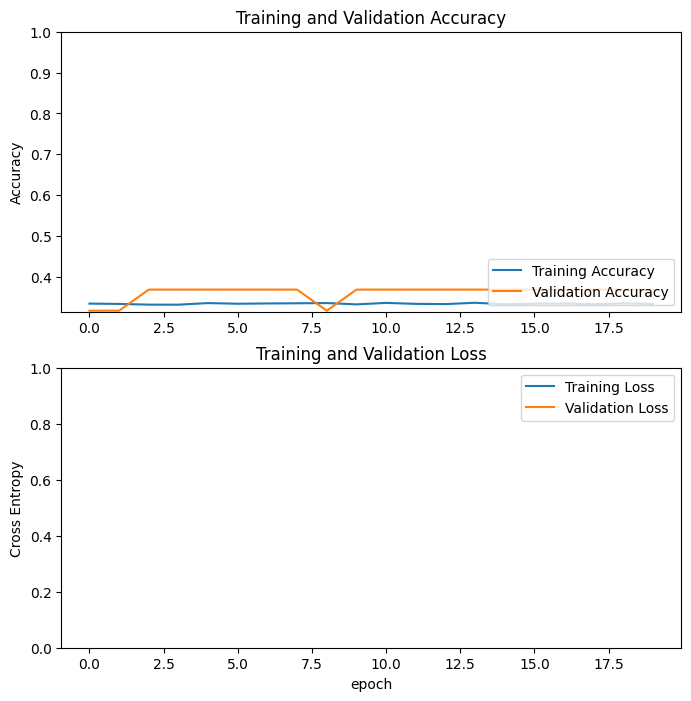

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
vgg16_stb_v1_2_7.save("VGG16-STBv1.2_10")

INFO:tensorflow:Assets written to: VGG16-STBv1.2_10/assets


INFO:tensorflow:Assets written to: VGG16-STBv1.2_10/assets


## **STOP HERE**

In [ ]:
from tensorflow.keras.layer import Activation


In [ ]:
def build_model_from_vgg16_stb_v1_2_1(hp):
  # try: 
    # model = vgg16_stb_v1_2_1
    model = tf.keras.models.clone_model(vgg16_stb_v1_2)

    # model.get_layer('dropout').rate = hp.Choice("Dropout",[0.10,0.125,0.15,0.20,0.25])
    # model.get_layer('dense_1').units = hp.Choice("dense_1",[64,128,256,512])
    # model.get_layer('dense_2').units = hp.Choice("dense_2",[128,256,512,1024])
    # model.get_layer('dense_3').units = hp.Choice("dense_3",[32,64,128,256,512])

    for m in model.layers[4].layers[-1:-5:-1]:
      m.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('adam_learning_rate', [5e-3, 1e-3])),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    return model
  

In [ ]:
from kerastuner.engine.hyperparameters import HyperParameters


<ipython-input-14-1b77be62db4d>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [ ]:
# Define the callback function to log the history of the training process
class HistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs={}):
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

# Define the hyperparameters
hp = HyperParameters()

In [ ]:
tuner = Hyperband(
    build_model_from_vgg16_stb_v1_2_1,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    overwrite=False,
    directory='/content/drive/My Drive/Tuner/',
    project_name='fine_tuner_3')

In [ ]:
# Define the callback to log the history of the training process
history_callback = HistoryCallback()

# Perform the hyperparameter search and log the history of the training process
# tuner.search(x_train, y_train,
#              epochs=100,
#              validation_data=(x_val, y_val),
#              callbacks=[history_callback])


In [ ]:
#@title Default title text
tuner.search(train_ds, epochs=15, validation_data=val_ds
            #  , callbacks=[history_callback]
             )

169/591 [=======>......................] - ETA: 1:36:23 - loss: 0.6033 - accuracy: 0.7419

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
# best_model.save('/content/drive/My Drive/Model/VGG_STBv1.2_3')

## Load the trails

## Evaluation and Predictions

In [ ]:
loss, accuracy = best_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

22/22 [==============================] - 205s 5s/step - loss: 1.5188 - accuracy: 0.3848
Test accuracy : 0.38483548164367676


In [ ]:
num_trials = 15
from kerastuner import HyperParameters
tuner_hps_summary = tuner.get_best_hyperparameters(num_trials=num_trials)

In [ ]:
summary_dict = {}
for i,a in enumerate(tuner_hps_summary):
  print(f"Best trial {i}:")

  trial_dict = {}
  for hp_name, hp_value in a.values.items():
      # print(f"{hp_value}")
      trial_dict[hp_name] = hp_value
  summary_dict[i] = trial_dict

Best trial 0:
Best trial 1:
Best trial 2:
Best trial 3:
Best trial 4:
Best trial 5:
Best trial 6:
Best trial 7:
Best trial 8:
Best trial 9:
Best trial 10:


In [ ]:
import pandas as pd

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame.from_dict(summary_dict, orient='index')

# Write the DataFrame to an excel file
df.to_excel('/content/drive/My Drive/Models/output-3_1.xlsx', na_rep='')

In [ ]:
print("Best hyperparameters:")

for i,trial in enumerate(tuner_hps_summary):
  print(f"Trial {i}")
  for hp_name, hp_value in trial.values.items():
      print(f"- {hp_name}: {hp_value}")